In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep=';')

In [114]:
#Дропаю колонку Unnamed: 0, т.к это индексы и они нам не пригодятся
df = df.drop(columns={'Unnamed: 0'})

In [115]:
#Смотрим на размеры наших выборок 
df.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [116]:
#Привожу колонку к типу float
df.value = df.value.apply(lambda x: x.replace(',', '.')).astype('float')

In [117]:
#Считаю среднее в выборках
df.groupby('experimentVariant', as_index=False).agg({'value': 'mean'})

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [118]:
#Считаю медианы в выборках
df.groupby('experimentVariant', as_index=False).agg({'value': 'median'})

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


In [119]:
df

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [120]:
#Вывожу размах выборок в контрольной группе
control_max= df.query('experimentVariant == "Control"').value.max()
control_min = df.query('experimentVariant == "Control"').value.min()
print(f'control_max= {control_max}, control_min= {control_min}')

control_max= 13.130345728722, control_min= 6.43654075863162


In [121]:
#Вывожу размах выборок в тестовой группе
Treatment_max= df.query('experimentVariant == "Treatment"').value.max()
Treatment_min= df.query('experimentVariant == "Treatment"').value.min()
print(f'Treatment_max= {Treatment_max}, Treatment_min= {Treatment_min}')

Treatment_max= 3000.0, Treatment_min= 6.43654075863162


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


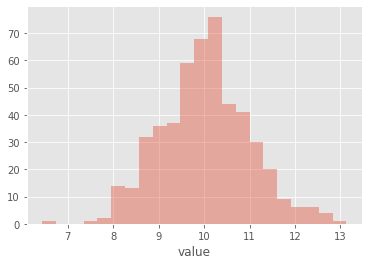

In [122]:
#Распределение контрольной выборки
sns.distplot(df[df.experimentVariant == 'Control'].value, kde=False)

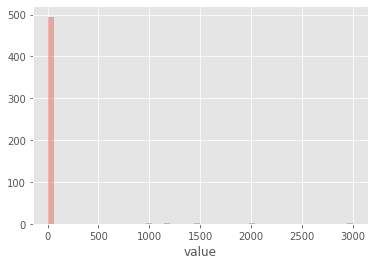

In [123]:
#Распределение тестовой выборки
sns.distplot(df[df.experimentVariant == 'Treatment'].value, kde=False)

# Анализ по распределениям
    В контрольной группе распределение напоминает нормальное, тогда как в тестовой группе распределение явно скошенное в левую сторону и появились сильные выбросы, в правую сторону.

In [124]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [125]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

In [126]:
n = 1000

sample_1 = np.random.exponential(scale=1/0.001, size=n)
sample_2 = np.random.exponential(scale=1/0.00101, size=n)

df1 = pd.DataFrame({
    "sample_1": sample_1,
    "sample_2": sample_2
})

In [127]:
df

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [128]:
#Проводим тест по Mann-Whitney
mannwhitneyu(df[df.experimentVariant == 'Treatment'].value, 
             df[df.experimentVariant == 'Control'].value)

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

In [129]:
#Проводим t-test
ttest_ind(df[df.experimentVariant == 'Treatment'].value, 
             df[df.experimentVariant == 'Control'].value)

Ttest_indResult(statistic=2.0729020485356604, pvalue=0.038437593613498765)

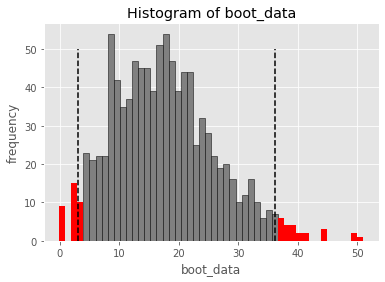

{'boot_data': [9.274694202544165,
  23.264815400142314,
  28.19438268186821,
  10.358252361202059,
  16.29815322132392,
  26.377888261836635,
  35.19714720765349,
  33.100320035508034,
  5.032453352752919,
  9.17524103554688,
  16.692842739808704,
  34.717163683538665,
  8.898160385564367,
  23.86958234328647,
  14.194615455145923,
  9.097459855460054,
  18.664552391166122,
  4.967431432668096,
  4.413904328367872,
  19.197426934231924,
  4.344278669064641,
  16.98405952136834,
  18.202876398588195,
  18.957611304972833,
  8.306644761351563,
  18.889027357320664,
  41.10623628020482,
  4.360503198628691,
  9.94653222682117,
  10.95018537740201,
  10.366178957850279,
  18.334178211816486,
  29.153167432462737,
  21.778203842250296,
  5.846989684805818,
  16.401688984756657,
  28.255357875454457,
  14.353932456589229,
  12.061168832125329,
  17.958885509317362,
  5.976095161013378,
  11.36287973313034,
  9.290550759798107,
  18.01731298854749,
  22.98167926201834,
  18.305020343707902,
 

In [130]:
#Провожу бусттрап для средней статистики
get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

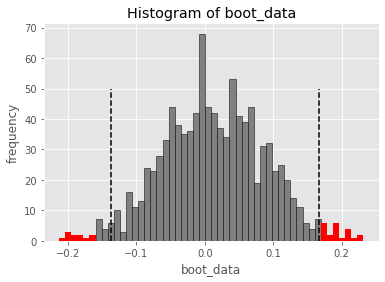

{'boot_data': [0.008706742979785353,
  -0.08240466808635638,
  -0.008459577185404576,
  -0.019880685560639932,
  -0.061052679647284336,
  0.00744072224295067,
  -0.15537670763802502,
  -0.034742803627049845,
  0.09542082510523997,
  -0.1537516315296399,
  -0.034233823256360374,
  0.039786180074634636,
  0.0827962214432496,
  0.01578689102718034,
  -0.025988500399685144,
  -0.06852285290492599,
  -0.18745112575949552,
  0.08397708664608494,
  0.06960533113074963,
  0.022445713017363644,
  0.02198535003084956,
  -0.07262492532338527,
  0.11033994988816964,
  0.05232428207706974,
  0.08560807876446486,
  0.07469388537775057,
  0.1364011883093994,
  0.06783889902275941,
  0.0501541976152442,
  -0.0030444577649291205,
  0.09263232728135051,
  -0.020949545560201344,
  0.09066751928034389,
  -0.036545052092650465,
  -0.06520836030436516,
  0.06275981600335001,
  0.002560760801165074,
  -0.1275382706463004,
  0.07107084843361466,
  0.037362468845755004,
  0.05926336947970512,
  0.0662339043191

In [131]:
#Провожу бусттрап для медианной статистики
get_bootstrap(
    df[df.experimentVariant == 'Treatment'].value, # числовые значения первой выборки
    df[df.experimentVariant == 'Control'].value, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

# Вывод
    t-test применимо к нашему заданию для достаточно больших выборок в количестве 500 измерений должен показывать достоверный порог значимости, но признак в тестовой группе распределен не нормально из за этого мы можем получить различные спецэффекты, и для более детальной оценки необходимо более детальная оценка данных.
    Тест Mann-Whitney не особо требовательный к данным, но он сложно интерпретируемый, т.к основывается на ранжировке наших значений.
    В Данном случае лучше всего воспользоваться бусттрэпом, для средних значений мы получим стат значимые различия, ну и не удивительно так как в тестовой выборке появились сильные выбросы, а для медианных значений мы получим большое значение p-value, которое схоже с тестом Mann-Whitney и не дает отвергнуть нулевую гипотезу о равенстве разности медианных значений в выборках